<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis (PCA)
Principal Component Analysis is an unsupervised dimensionality reduction technique used to transform a high-dimensional dataset into a lower-dimensional space while retaining the most important patterns and variations in the data. The algorithm identifies orthogonal axes, known as principal components, that capture the maximum variance in the data. These components are ordered by their significance, with the first component explaining the most variance and subsequent components explaining the remaining variance in decreasing order. By projecting the data onto the selected principal components, PCA effectively reduces its dimensionality (number of features), making it easier to visualize and analyze while preserving essential information.






### Import libraries and initialize random generator

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphing
np.random.seed(0)

### Read data from CSV
We will use the wholesale customers dataset. The data set includes the annual spending amount on 8 product categories of 440 customers. We will try to group these customers into different clusters, which in real life may represent groups such as individual buyers, business owners, tourists ... (these are just examples)

https://archive.ics.uci.edu/dataset/292/wholesale+customers

In [56]:
dataset = pd.read_csv("https://raw.githubusercontent.com/TrainingByPackt/Data-Science-with-Python/master/Chapter01/Data/Wholesale%20customers%20data.csv")
display(dataset)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


Channel and Region are categorical variables, so these feature are not suitable for GMM. We will therefore remove them

In [57]:
dataset = dataset.drop(['Channel', 'Region'], axis=1)

We have a total of 440 data samples, and 6 features

In [58]:
print(dataset.shape)
n_samples = dataset.shape[0]
n_features = dataset.shape[1]

(440, 6)


In [59]:
# Convert the dataset into a numpy matrix
X = dataset.to_numpy()
display(X)

array([[12669,  9656,  7561,   214,  2674,  1338],
       [ 7057,  9810,  9568,  1762,  3293,  1776],
       [ 6353,  8808,  7684,  2405,  3516,  7844],
       ...,
       [14531, 15488, 30243,   437, 14841,  1867],
       [10290,  1981,  2232,  1038,   168,  2125],
       [ 2787,  1698,  2510,    65,   477,    52]])

### Standardizing dataset values
We can standardize features by removing the mean and scaling to unit variance, so all features are treated equally.

In [60]:
def mean(x):
    return sum(x)/len(x)

def std(x):
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

dataset_standardized = ( X - mean(X) )  /  std(X)
display(dataset_standardized)

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

### Covariance matrix

In statistics, the covariance matrix is a fundamental concept used to understand the relationships between multiple variables in a dataset. It provides a measure of how two variables vary together. The covariance matrix is a square matrix where each element represents the covariance between two variables.

Let's assume we have a dataset with 'n' observations and 'm' variables. The covariance matrix, denoted as $\mathbf{C}$, is an $m \times m$ matrix, where the $(i,j)$th element represents the covariance between variables $X_i$ and $X_j$:

$$
\mathbf{C} = \begin{bmatrix}
\text{cov}(X_1, X_1) & \text{cov}(X_1, X_2) & \dots & \text{cov}(X_1, X_m) \\
\text{cov}(X_2, X_1) & \text{cov}(X_2, X_2) & \dots & \text{cov}(X_2, X_m) \\
\vdots & \vdots & \ddots & \vdots \\
\text{cov}(X_m, X_1) & \text{cov}(X_m, X_2) & \dots & \text{cov}(X_m, X_m) \\
\end{bmatrix}
$$

The diagonal elements of the covariance matrix ($C_{ii}$) represent the variance of each variable, and the off-diagonal elements ($C_{ij}$ where $i \neq j$) represent the covariances between different pairs of variables.

The covariance between two variables, $X_i$ and $X_j$, is given by the following formula:

$$
\text{cov}(X_i, X_j) = \frac{1}{n-1} \sum_{k=1}^{n} (X_{ki} - \bar{X}_i) \cdot (X_{kj} - \bar{X}_j)
$$

Where:
- $X_{ki}$ and $X_{kj}$ are the values of variable $X_i$ and $X_j$ for the $k$th observation, respectively.
- $\bar{X}_i$ and $\bar{X}_j$ are the means of variables $X_i$ and $X_j$ across all observations.

The matrix can be computed using the following:
$$\mathbf{C} = \frac{X^T \cdot X}{n-1}$$


In [61]:
def covariance(x):
    n = x.shape[0]
    return (x.T @ x)/(n-1)

cov_mat = covariance(dataset_standardized)

### Finding eigenvectors and eigenvalues of the covariance matrix (eigendecomposition of covariance matrix)


In [63]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [2.65099857 1.70646229 0.74175057 0.56501435 0.06311455 0.28632709]
Eigenvectors 
 [[-0.04288396 -0.52793212 -0.81225657 -0.23668559  0.03602539  0.04868278]
 [-0.54511832 -0.08316765  0.06038798 -0.08718991  0.03804019 -0.82657929]
 [-0.57925635  0.14608818 -0.10838401  0.10598745 -0.72174458  0.31499943]
 [-0.05118859 -0.61127764  0.17838615  0.76868266  0.01563715  0.02793224]
 [-0.5486402   0.25523316 -0.13619225  0.17174406  0.68589373  0.33964012]
 [-0.24868198 -0.50420705  0.52390412 -0.55206472  0.07513412  0.31470051]]


In [64]:
# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [2.65099857 1.70646229 0.74175057 0.56501435 0.06311455 0.28632709]
Eigenvectors 
 [[ 0.04288396  0.54511832  0.57925635  0.05118859  0.5486402   0.24868198]
 [ 0.52793212  0.08316765 -0.14608818  0.61127764 -0.25523316  0.50420705]
 [ 0.81225657 -0.06038798  0.10838401 -0.17838615  0.13619225 -0.52390412]
 [-0.23668559 -0.08718991  0.10598745  0.76868266  0.17174406 -0.55206472]
 [-0.03602539 -0.03804019  0.72174458 -0.01563715 -0.68589373 -0.07513412]
 [-0.04868278  0.82657929 -0.31499943 -0.02793224 -0.33964012 -0.31470051]]


### Sorting the eigenvectors and eigenvalues
Here, we sort eigenvalues in descending order.

In [65]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

for e in eig_pairs:
  print(e)


(2.6509985696168084, array([0.04288396, 0.54511832, 0.57925635, 0.05118859, 0.5486402 ,
       0.24868198]))
(1.7064622949947312, array([ 0.52793212,  0.08316765, -0.14608818,  0.61127764, -0.25523316,
        0.50420705]))
(0.7417505705584576, array([ 0.81225657, -0.06038798,  0.10838401, -0.17838615,  0.13619225,
       -0.52390412]))
(0.5650143486980587, array([-0.23668559, -0.08718991,  0.10598745,  0.76868266,  0.17174406,
       -0.55206472]))
(0.2863270874218252, array([-0.04868278,  0.82657929, -0.31499943, -0.02793224, -0.33964012,
       -0.31470051]))
(0.06311455467822623, array([-0.03602539, -0.03804019,  0.72174458, -0.01563715, -0.68589373,
       -0.07513412]))


### Explained variance
We can graph out the explained variance of each principle component.

Explained variance: [44.08289288 28.37639953 12.3344129   9.39550375  4.7612724   1.04951854]


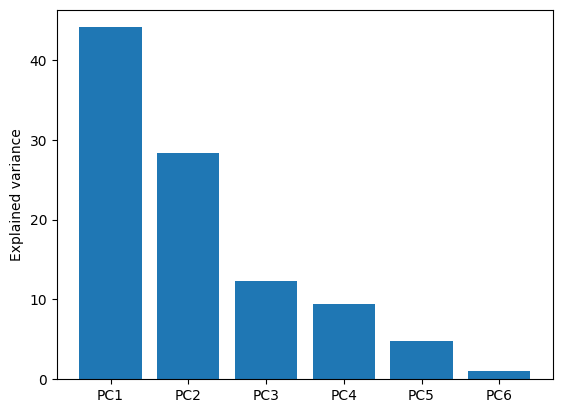

In [67]:
eig_vals_total = sum(eig_vals)
# convert the eigenvalues to percentage of the total sum of all eigenvalues
explained_variance = eig_vals_sorted/eig_vals_total * 100

print('Explained variance:',explained_variance)

plt.bar(['PC1','PC2','PC3','PC4','PC5','PC6'],explained_variance)
plt.ylabel('Explained variance');

we now graph out the cumulative explained variance of the 8 principal components. From the graph, we can see that just 3 principal components accounts for 72% of the explained variance.

Cumulative explained variance: [ 44.08289288  72.45929241  84.7937053   94.18920906  98.95048146
 100.        ]


Text(0, 0.5, 'Cumulative explained variance')

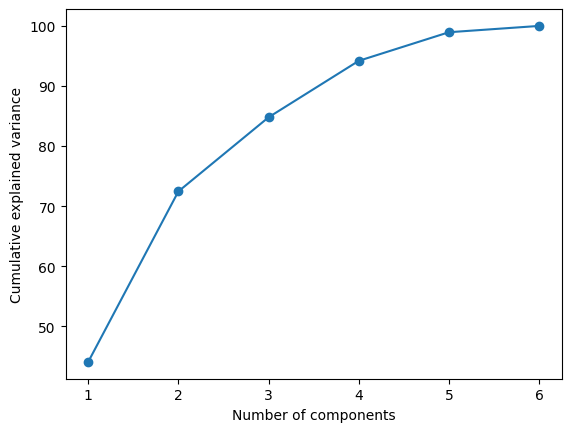

In [68]:
cumulative_explained_variance = np.cumsum(explained_variance)
print('Cumulative explained variance:',cumulative_explained_variance)

plt.plot([1,2,3,4,5,6], cumulative_explained_variance, '-o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

### Dimension reduction
we choose the top k eigenvectors where  k is the number of dimensions of the new feature subspace to reduce the dimension (number of features) in our dataset.

In [70]:
# Select top k eigenvectors
k = 2
W = eig_vecs_sorted[:k, :] # Projection matrix

print(W)

[[ 0.04288396  0.54511832  0.57925635  0.05118859  0.5486402   0.24868198]
 [ 0.52793212  0.08316765 -0.14608818  0.61127764 -0.25523316  0.50420705]]


### Project the dataset
With the transformation matrix, we can now transform the dataset using the projection matrix  W to obtain a k-dimensional feature subspace.

In [71]:
X_proj = dataset_standardized.dot(W.T)
print(X_proj.shape)

(440, 2)


### Visualization of the projection

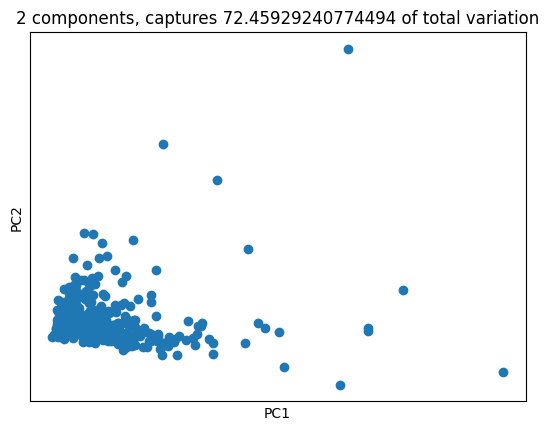

In [72]:
plt.scatter(X_proj[:, 0], X_proj[:, 1])
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cumulative_explained_variance[1]))

### Silhouette Score
The silhouette score is a measure of how well-defined the clusters are in a clustering algorithm. It quantifies how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to +1, where a higher value indicates better-defined clusters.

$$ \text{Silhouette Score} = \frac{{\sum_{i=1}^{N} (b_i - a_i)}}{{\max(a_i, b_i)}}
$$

- $N$ is the number of data points,
- $a_i$ is the average distance of data point $i$ to other points within the same cluster,
- $b_i$ is the average distance of data point $i$ to the points in the nearest neighboring cluster.

 Higher scores indicate better clustering results, while negative scores imply that data points may have been assigned to the wrong clusters.

In [91]:
from sklearn.metrics import silhouette_score

import numpy as np

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def pairwise_distances(dataset):
    num_points = len(dataset)
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distances[i, j] = euclidean_distance(dataset[i], dataset[j])
            distances[j, i] = distances[i, j]
    return distances

def silhouette_score(dataset, cluster_labels):
    distances = pairwise_distances(dataset)
    num_points = len(dataset)
    silhouette_scores = np.zeros(num_points)

    for i in range(num_points):
        a_i = np.mean([distances[i, j] for j in range(num_points) if cluster_labels[j] == cluster_labels[i]])

        b_i = float('inf')
        for cluster in set(cluster_labels):
            if cluster != cluster_labels[i]:
                b_i_temp = np.mean([distances[i, j] for j in range(num_points) if cluster_labels[j] == cluster])
                b_i = min(b_i, b_i_temp)

        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0

    return np.mean(silhouette_scores)

### Comparison of clustering (before vs. after PCA)
We will run K-means clustering on the dataset before and after the PCA pre-processing. We can see that the Silhouette Score increased after using PCA, so PCA has improved the result.

In [92]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(dataset_standardized)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Get the Silhouette Score
silhouette_avg = silhouette_score(dataset_standardized, cluster_labels)
print("Silhouette Score:", silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5432017726264434


In [93]:
k = 3
W = eig_vecs_sorted[:k, :] # Projection matrix
dataset_proj = dataset_standardized.dot(W.T)


kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(dataset_proj)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Get the Silhouette Score
silhouette_avg = silhouette_score(dataset_proj, cluster_labels)
print("Silhouette Score:", silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5769718825380535


## References
- https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/
- https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
- https://www.youtube.com/watch?v=FgakZw6K1QQ
- https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering
- https://www.kaggle.com/code/kashnitsky/a7-demo-unsupervised-learning/notebook